In [1]:
import ssdeep
import pickle,os,sys,gc
import pandas as pd
# pd.set_option('display.max_columns', None)
import numpy as np
from tqdm import tqdm
from collections import Counter
import multiprocessing as mp
from multiprocessing import Process, Manager, Pool
import subprocess
from multiprocessing import Pool 
import time,datetime
from itertools import chain
import math
from operator import itemgetter
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
import functools
import itertools
import operator

In [2]:
#  import sys,os
print(sys.executable)
print(sys.version)
print(sys.version_info)
import findspark
# os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3' #'/home/antslab/anaconda3/bin/python'
findspark.init()
import pyspark
# from pyspark import SparkContext
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row, SQLContext, SparkSession, window
from pyspark import SparkConf, SparkContext
# Import data types
from pyspark.sql.types import *
import  pyspark.sql.functions as F
conf = SparkConf()
# conf.set("spark.local.dir", "/mnt/ssd240g/data/Leo_Spark_Home/tmp")
conf.set("spark.executor.cores","12")
conf.setMaster("local[12]")
conf.set("spark.driver.memory","250g") #滿載165G/
conf.set("spark.executor.memory", "95g")
conf.set("spark.memory.offHeap.enabled","true")
conf.set("spark.memory.offHeap.size","85g")
conf.set("spark.driver.extraJavaOptions","-Xss80g")
conf.set("spark.driver.extraJavaOptions","-Xms80g")
# conf.set("spark.memory.storageFraction","0.2")
# conf.set("spark.driver.maxResultSize","0")
# conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
# conf.set("spark.sql.execution.arrow.enabled", "true")
conf.set("spark.kubernetes.pyspark.pythonVersion","3")
conf.set("spark.network.timeout","1000s")
conf.set("spark.sql.shuffle.partitions",100000)
conf.set("spark.driver.maxResultSize", "150g")

# spark = SparkSession.builder.appName("pcap_analyzer").config(conf=conf).getOrCreate() #pcap_analyzer pcapAnalyzer
spark = SparkSession.builder.master("local").appName("Test_spark").config(conf=conf).getOrCreate()
# spark.conf.set("spark.sql.execution.arrow.enabled", True)
spark.conf.set("spark.sql.debug.maxToStringFields", 290000)
spark.conf.set("spark.sql.hive.filesourcePartitionFileCacheSize",100*1024*1024*1024)

import databricks.koalas as ks
ks.options.display.max_rows = 20
ks.set_option('compute.max_rows', None)
# ks.set_option('compute.ops_on_diff_frames', True)
ks.set_option('compute.default_index_type', 'distributed')
print(ks.__version__,spark.version)
spark

/home/antslab/anaconda3/bin/python
3.7.7 (default, Mar 26 2020, 15:48:22) 
[GCC 7.3.0]
sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)
1.2.0


'3.0.0'

In [3]:
isp = '台灣之星' #All

in_file = np.nan
pickle_dir = np.nan
picture_dir = np.nan
df2 = ""
def create_orifinalDF(time):
    """
    GOAL: preprocess original df
    time: e.g., 20200101
    
    Return: df2
    """
    
    global in_file,pickle_dir,picture_dir #in file HDFS?
#     in_file = 'hdfs://192.168.50.123:8020/user/hdfs/parquet/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/session_parquet/'+str(time)+'_session.parquet'
    in_file = 'hdfs://192.168.50.200/user/hdfs/parquet/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/session_parquet/'+str(time)+'_session.parquet'
#     in_file = '/home/antslab/data_hdd4t/pcap_process/pcap_spark/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/中華電信/parquet/2020_01_10_session_v7-2_hashpayload_time_size.parquet'  
    pickle_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pickles/'
    picture_dir = '/home/antslab/NAS1_RAID6/pcap_inter/'+str(time[:4])+'_'+str(time[4:6])+'_'+str(time[6:])+'/'+isp+'/case_pictures/'
    
    if not os.path.exists(pickle_dir):
        os.makedirs(pickle_dir,exist_ok=True)
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True)    
    df = ks.read_parquet(in_file)
#     print(df.columns)
    df = df[['session_time','session_time_list','session_duration', 'session_i_tt_packet', 'session_o_tt_packet',
                 'session_i_tt_frame_length','session_o_tt_frame_length', 'udp_i_tt_length',
                 'udp_o_tt_length', 'udp_i_avg_length', 'udp_o_avg_length','icmp_i_avg_length', 'icmp_o_avg_length',
                 'icmp_i_tt_datagram_length','icmp_o_tt_datagram_length',
                 'tcp_i_tt_payload_length','tcp_o_tt_payload_length', 'tcp_i_avg_payload_length',
                 'tcp_o_avg_payload_length','ip_src', 'ip_dst','tcp_srcport', 'tcp_dstport', 'country','isp',
                 'domain', 'frame_i_max_protocols','frame_o_max_protocols', 'tcp_i_payload_list', 'tcp_o_payload_list'        
                ]]
     #篩選出有in bound payload的session
    df1 = df[(df.session_duration>0.1)&(df.session_i_tt_packet>1)&(df.session_i_tt_frame_length>0)&
             (df.tcp_i_payload_list.astype(str)!='[]')]
    df1 = df1[(df1.udp_i_tt_length>0)|(df1.udp_i_avg_length>0)|(df1.icmp_i_avg_length>0)|
            (df1.icmp_i_tt_datagram_length>0)|(df1.tcp_i_tt_payload_length>0)|(df1.tcp_i_avg_payload_length>0)]

    df2 = df1[(df1.tcp_o_payload_list.astype(str)!='[]')&(df1.session_o_tt_packet>0)&(df1.session_o_tt_frame_length>0)]
    df2 = df2[(df2.udp_o_tt_length>0)|(df2.udp_o_avg_length>0)|(df2.icmp_o_avg_length>0)|
            (df2.icmp_o_tt_datagram_length>0)|(df2.tcp_o_tt_payload_length>0)|(df2.tcp_o_avg_payload_length>0)]
    df2 = df2[(df2.domain != 'googlebot.com')|(df2.isp!='Googlebot')] #
    gc.collect()
    df2 = df2.to_pandas() #記憶體可能會不夠?
#     print(time,"=> 所有protocol總和中，1.原本的session總數:",len(df)," 2.in-bound具有payload的session總數:",len(df1)," 3.in-與out-bound都具有payload的session總數(最終拿來進行分群的sessions):",len(df2))

    #     print(df2.frame_i_max_protocols.value_counts().head(60))
#     print(df2.frame_o_max_protocols.value_counts().head(60))
#     print(df2.domain.value_counts().head(60))
#     print(df2.isp.value_counts().head(60))
#     protocol_name = 'tds'
#     df2_tds = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
#     print(time,'TDS sessions數量:',len(df2_tds),'TDS占所有protocols之sessions比例:',len(df2_tds)/len(df))
    return df2,pickle_dir,picture_dir#,df2_tds

### Function

In [4]:
def prepare_df(df2,protocol_name='http',split="size",loner=False):
    protocol_name = str(protocol_name).lower()
    '''
    df2: filterout no payload's all sessions df
    protocol_name: what TCP protocol string would be contained e.g., smb,http,tds...
    loner: 用來檢查不同天相同protocol的分群
    
    return1: protocol original dataframe (session-based)
    return2: protocol payload dataframe (packet-based)
    '''
    def sort_fn(data):
        '''
        sort by time: itemgetter(1)
        sort by size: itemgetter(2)
        '''
        if split=='size':
            return sorted(data,key=itemgetter(2))
        elif split == 'time':
            return sorted(data,key=itemgetter(1))
                    
    def split_col_len(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
#         packet_payload = []
        packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
    #         packet_payload.append(ssdeep_hash)
            packet_len.append(ssdeep_hash.split(':')[0])
        return packet_len#,packet_payload

    def split_col_hash(session):
        '''
        input: list(session) of lists(packets) =>tuple=(hash,time)

        Return1: list of ssdeep length
        Return2: list of session's packets hashes
        '''
    #     for session in payload_li:
        packet_payload = []
#         packet_len = []
        for packet in session:
            ssdeep_hash = packet[0]
            packet_payload.append(ssdeep_hash)
    #         packet_len.append(ssdeep_hash.split(':')[0])
        return packet_payload
    if not loner:
        df2_protocol = df2[(df2.frame_i_max_protocols.str.contains(protocol_name))&(df2.frame_o_max_protocols.str.contains(protocol_name))]
    else:
        df2_protocol = df2
    df2_protocol_payload = df2_protocol[['tcp_i_payload_list']]
    df2_protocol_payload['tcp_i_payload_list'] = df2_protocol_payload.tcp_i_payload_list.apply(sort_fn) #map
    df2_protocol_payload['size'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_len) #,df2_protocol_payload['hash']
    df2_protocol_payload['hash'] = df2_protocol_payload.tcp_i_payload_list.map(split_col_hash)
    L_size = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['size']]
    L_hash = [x if isinstance(x, list) else [x] for x in df2_protocol_payload['hash']]
    df2_protocol_payload = pd.DataFrame({
        'idx':df2_protocol_payload.index.values.repeat([len(x) for x in L_size]),
        'size':list(chain.from_iterable(L_size)),
        'hash':list(chain.from_iterable(L_hash))
        })
    # df2_protocol_payload['idx'] = 
    df2_protocol_payload['size'] = df2_protocol_payload['size'].astype(int)
    if not loner:
        return df2_protocol, df2_protocol_payload
    else:
        return df2_protocol_payload

In [5]:
def similarity_compare(df2_protocol,df2_protocol_payload,ori_protocol=None,ori_protocol_payload=None,thr=0,thr2=10,loner=False): #40
    '''
    GOAL: compare with timestamp's q1,q2,q3 to similar size packet. Calculate max/mean value for score.
    df2_protocol: protocol original dataframe (session-based)
    df2_protocol_payload: protocol payload dataframe (packet-based)
    loner:需指派ori_protocol、ori_protocol_payload
    
    Return: dictionary with each cluster 
    '''
    def ssdeep_compare(target_hash,candidate_df):
        '''
        Input1: string of hash
        Input2: dataframe of candidate
        '''
        def compare(candidate_hash):
            return ssdeep.compare(target_hash,candidate_hash)
        return candidate_df.hash.map(compare)
    big_dict_protocol = {}
    big_dict_protocol_score = {}
#     big_dict_protocol2 = {} #test
    used_idx_li = []
    all_scores = [] #test2
    for idx in df2_protocol.index:
        if idx in used_idx_li:
            continue
        target = df2_protocol_payload[df2_protocol_payload.idx == idx]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q1 = int(t_len*0.25)
        q2 = int(t_len*0.5)
        t_q1 = target.iloc[q1,-1]
        if not loner:
            candidate = df2_protocol_payload[df2_protocol_payload.idx!=idx]
            candidate = candidate[~candidate.idx.isin(used_idx_li)] #candidat不可重複分群
        else:
            t_ip = df2_protocol[df2_protocol.index == idx].ip_src.values[0]
            candidate_idx = ori_protocol[ori_protocol.ip_src == t_ip].index.tolist()
            candidate = ori_protocol_payload[ori_protocol_payload.idx.isin(candidate_idx)] #可重複分群?
        
        candidate['idx'] = candidate.idx.astype(str)
#         candidate_q1 = candidate[candidate['size']==target.iloc[q1,-2]] #rule
        candidate['q1'] = ssdeep_compare(t_q1,candidate) #rule:candidate_q1
        if q2 != q1:
            t_q2 = target.iloc[q2,-1]
            q3 = int(t_len*0.75)
#             candidate_q2 = candidate[candidate['size']==target.iloc[q2,-2]] #rule
            candidate['q2'] = ssdeep_compare(t_q2,candidate) #rule:candidate_q2
            if q3 != q2:
                t_q3 = target.iloc[q3,-1]
#                 candidate_q3 = candidate[candidate['size']==target.iloc[q3,-2]] #rule
                candidate['q3'] = ssdeep_compare(t_q3,candidate) #rule:candidate_q3
                if t_len>4:
#                     t_min = target.iloc[0,-1] 
#                     candidate['min'] = ssdeep_compare(t_min,candidate)
                    t_max = target.iloc[-1,-1]
                    candidate['max'] = ssdeep_compare(t_max,candidate)
                    
        candidate = candidate.drop(['size','hash'],axis=1)
        candidate['score'] = candidate.mean(axis=1) #max
        score_li = candidate.score.tolist() #test2
        candidate = candidate[candidate.score>thr] #相似度分數，數字越小速度愈快、數字越大越多群
        candidate['idx'] = candidate.idx.astype(int)
#         candidate2 = candidate[candidate.score<thr2] #test
        idx_li = list(set(candidate.idx.tolist()))
#         idx_li2 = list(set(candidate2.idx.tolist())) #test
        all_scores.extend(score_li) #test2
        if len(idx_li)>0:
            
            used_idx_li.extend(idx_li)
            used_idx_li.append(idx)
            if not loner:
                big_dict_protocol[idx] = idx_li
                big_dict_protocol_score[idx] = candidate.score.tolist()
            else:
                big_dict_protocol[t_ip+'_'+str(idx)] = idx_li
                big_dict_protocol_score[t_ip+'_'+str(idx)] = candidate.score.tolist()                
#         if len(idx_li2)>0: #test
#             big_dict_protocol2[idx] = idx_li2 # test
    return big_dict_protocol,sorted(list(set(df2_protocol.index)-set(used_idx_li))),all_scores,big_dict_protocol_score #test

In [6]:
def write2pkl(df2_protocol,big_dict,cluster_key,case_id,path=pickle_dir):
    '''
    GOAL: output 3-tuple to draw time diagram
    df2_protocol: original dataframe session-based
    big_dict: big_dict_protocol
    cluster_key: print by find_cluster function
    case_id: user defined to identify
    '''
    cluster_key = int(cluster_key)
#     print(big_dict[cluster_key])
    temp_li = big_dict[cluster_key][:]
#     print(temp_li)
    temp_li.append(cluster_key) #最後一個session才是key (target)，其他人(candidates)都是跟他(target)比
#     print(temp_li)
#     temp_li = temp_li2[:]
    case_diagram = df2_protocol.loc[list(set(temp_li))]
    time_lists = case_diagram.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = case_diagram.ip_src.tolist()
    countries = case_diagram.country.tolist()
#     print('Unique Country#:',len(set(countries)),"Unique IP#:",len(set(ips)),'Session#:',len(time_lists))
    # pickle_dir = '/home/antslab/spark_data/pcap_inter/2020_01_10/中華電信/case_pickles/'
    pickle.dump(obj=(time_lists,ips,countries),file=open(path+'case#'+str(case_id)+'_threetuples.pkl','wb'))        


In [7]:
def find_cluster(big_dict,idx):
    '''
    big_dict: big_dict_protocol
    idx: which idx want to find
    Return cluster id (big_dict"s key number')
    '''
    idx = int(idx)
    try:
        big_dict[idx] #KeyError
        return idx
    except KeyError:
        for k,v in big_dict.items():
            if idx in v:
                return k
                break

In [8]:
def cluster_stat(protocol_big_dict,protocol_df,proto,date,picture_dir,drawlog=False):
    """
    GOAL: output statistic of certain protocol
    input1: dict from similarity_compare
    inpit2: df from prepare_df
    """
    
    all_nums = []
    clus_id = []
    # all_num = 0
    for k,v in protocol_big_dict.items():
    #     all_nums.extend(v)
        all_nums.append(len(v))
        clus_id.append(k)
    #     all_num +=len(v)
    clus_num = len(all_nums)
    print("原本總共sessions#:",len(protocol_df))
    print("共有#sessions可分群:",sum(all_nums)+clus_num,"共有#lonerSessions:",len(protocol_df)-(sum(all_nums)+clus_num))
    print("可分為#群:",clus_num)
#     print(sum(all_nums)+len(all_nums),len(protocol_df)-(sum(all_nums)+len(all_nums)),len(protocol_df))
    protocol_stat_df = pd.DataFrame(all_nums,index=clus_id)
    protocol_stat_df[0] = protocol_stat_df[0]+1
    print("前五大的cluster key與對應之群集大小\n",protocol_stat_df[0].nlargest(5))
    print(protocol_stat_df.describe())
    protocol_stat_df  = pd.DataFrame(all_nums,index=[x for x in range(len(all_nums))])
    protocol_stat_df.hist(bins=100)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist'+'.png', dpi=300, format='png')
    
    temp = dict(Counter(all_nums))
    temp = {k: v for k, v in sorted(temp.items(), key=lambda item: item[0])}
#     temp = sorted(all_nums,reverse=True)
    x_axis = [k for k in temp.keys()] #群中所含的數量
    y_axis = [v for v in temp.values()] #該數量共有幾群為此
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,y_axis,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" cluster# of cluster's size",fontsize=30,ha='center')
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
    plt.xlabel("cluster size", fontsize=25, labelpad = 15)
    plt.ylabel("cluster #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clusternumber_line'+'.png', dpi=300, format='png')
#     plt.show()    
    
#log diagram
    fig, ax = plt.subplots()
    ax.set_yscale('log')
    protocol_stat_df.hist(ax=ax, bins=100, bottom=0.1)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_hist_log'+'.png', dpi=300, format='png')
    
    return len(protocol_df)-(sum(all_nums)+clus_num),protocol_stat_df.describe()

In [9]:
def cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point,date='0110',protocol='http'):
    '''
    GOAL: create each cluster's representaion ssdeep hash
    proto_df_payload: from prepare_df() function
    proto_big_dict: from similarity_compare() function
    proto_loners: loner idx list
    knee_point: from get_small_cluster() function
    date & protocol: user_defined cluster name
    
    Return: dict[cluster_name]: ssdeep hash
    '''
    upgma_dict = {}
    for key,value in proto_big_dict.items(): #cluster rep ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        if len(value)>knee_point:
            upgma_dict[str(protocol)+'_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
        else:
            upgma_dict[str(protocol)+'_S_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    for key in proto_loners: #loner ssdeep
        target = proto_df_payload[proto_df_payload.idx == key]
        target = target.reset_index(drop=True)
        t_len = len(target)
        q2 = int(t_len*0.5)
        q2_hash = target.iloc[q2,-1]
        country = proto_df.loc[key,'country']
        ip = proto_df.loc[key,'ip_src']
        domain = proto_df.loc[key,'domain']
        upgma_dict[str(protocol)+'_L_'+str(key)+'_'+str(date)+'_'+str(country)+'_'+str(domain)+'_'+str(ip)] = q2_hash
    return upgma_dict



def pair_wise_score(upgma_dict):
    '''
    GOAL: calculate distance matrix by calculating paire-wise similarity score. 
    and pick upper triangle convert to list
    Input: from cluster_rep_hash() function
    ['cluster']: name
    ['ssdeep']: cluster's representation hash
    
    Return: df=>['c_ssdeep_li']:the hashes list compare to, ['score']:list of distances (upper-triangle, exclude self)
    '''
    def compare(target_hash,candidate_hash_li):
        score_li = []
        for c_hash in candidate_hash_li:
            score_li.append(100-ssdeep.compare(target_hash,c_hash)) #相似度滿分100，轉換成距離最近0
        return score_li
    used_idx = []
    def create_hash_li(t_hash):
        idx_set = set(upgma_df[upgma_df.ssdeep == t_hash].index)#[0]
        same_hash_li = sorted(list(idx_set - set(used_idx)))
        idx = same_hash_li[0]
        used_idx.append(idx)
        return upgma_df.loc[idx+1:]['ssdeep'].tolist()
    upgma_df = pd.DataFrame(upgma_dict.items(),columns=['cluster','ssdeep'])
    upgma_df['c_ssdeep_li'] = upgma_df.ssdeep.map(create_hash_li)
    upgma_df['score'] = upgma_df.apply(lambda x: compare(x.ssdeep, x.c_ssdeep_li), axis=1)
    return upgma_df



def draw_upgma(upgma_df,picture_dir=picture_dir,name='upgma'):
    '''
    GOAL: using upper triangle's distance to draw upgma
    Input: from pair_wise_score() function
    Output: diagram of UPGMA、Z info
    '''
    if not os.path.exists(picture_dir):
        os.makedirs(picture_dir,exist_ok=True) 
    score_li = upgma_df['score'].tolist()
    score_li = list(filter(None, score_li))
    score_li = sum(score_li,[])
    Z = linkage(score_li, 'average')
    fig = plt.figure(figsize=(60, 24)) #(25,10) #(5,2)
    # plt.savefig(fig)
    dn = dendrogram(Z,labels=upgma_df.cluster.tolist())
    plt.savefig(picture_dir+str(name)+'.png', dpi=600, format='png', bbox_inches='tight')
    return dn,Z

In [17]:
def knee_point(length_li,proto='http',date='20200110',k=100):
    """
    每個list值所包含數量的變化量，也就是點的密集度變化量 (並非list自己本身值的變化量)
    length_li: 長度的list
    k: slope topK's knee points
    Return dict format (key is the answer)
    """
    length_dict = dict(Counter(length_li))
    sorted_dict = {k: v for k, v in sorted(length_dict.items(), key=lambda x: x[1])}
    all_items_num = sum(list(length_dict.values()))
#     for item in sorted_dict.items():
    all_keys = list(sorted_dict.keys())
    all_values = list(sorted_dict.values())
    slope_li = []
    for i in range(len(sorted_dict)):
        length1 = all_keys[i]
        try:
            length2 = all_keys[i+1]
        except IndexError:
            break
        value1 = sum(all_values[:i+1])
        value2 = sum(all_values[:i+2])
        slope = ((value2-value1)/all_items_num)/(length2-length1)
        slope_li.append(slope)
    change_rate_li = []
    for i in range(len(slope_li)):
        try:
            slope1 = slope_li[i]
            slope2 = slope_li[i+1]
        except IndexError:
            break
        change_rate_li.append(abs(slope2-slope1)) #陡變緩或是緩變陡的都一起算
    idx_li = sorted(range(len(change_rate_li)), key=lambda i: change_rate_li[i], reverse=True)[:k]
    return_dict = {}
    for idx in idx_li:
        return_dict[all_keys[idx+1]] = change_rate_li[idx]
    ##畫圖可再自行修改
    temp = sorted(length_li,reverse=True)
    x_axis = [x for x in range(len(temp))] #隨便給個編號當成X軸
    plt.figure(figsize=(30,20),dpi=300,linewidth = 1) # 圖片大小、折線寬度
    plt.plot(x_axis,temp,'o-',color = 'b', label=proto) #折現的型態、折現的顏色
#     plt.title(, x=0.5, y=1.03)
    plt.figtext(.5,.9,str(date)+" "+str(proto)+" clusters' size",fontsize=30,ha='center')
#     plt.xticks(fontsize=20)
#     plt.yticks(fontsize=20)
#     plt.xlabel("cluster ID", fontsize=25, labelpad = 15)
#     plt.ylabel("session #", fontsize=25, labelpad = 20)
    # plt.ylim(0, 2500)
    # plt.legend(loc = "best", fontsize=20)
    plt.savefig(picture_dir+str(proto)+'_'+str(date)+'_clustersize_line'+'.png', dpi=300, format='png')
#     plt.show()
    return pd.DataFrame.from_dict(return_dict,orient='index',columns=['knee_slope'])

In [11]:
def get_small_cluster(proto_big_dict,proto_loner_num,q1_num,proto,date):
    '''
    proto_big_dict: big dict from similarity_compare() func. (用以獲得各群的member數量)
    proto_loner_num: the protocol's loner numbers
    q1_num: 25%'s members# from
    
    Return: how many lesser is small cluster to deal as loner  (dict's member num)
    '''
    proto_dict_len = {}
    for k,v in proto_big_dict.items():
        proto_dict_len[k] = len(v)+1
    temp = list(proto_dict_len.values())
    for i in range(proto_loner_num):
        temp.append(1)
    temp = sorted(temp,reverse=True)
    temp_df = knee_point(temp,proto=proto,date=date)
    temp_score = temp_df.index.tolist()
    try:
        if temp_df.index[0] <q1_num:
            return temp_df.index[0]-1
        else:
            for score in temp_score:
                if score <q1_num:
                    return int(score)-1 #往後找其他knee point要小於q1
            return 0 #都不合<q1
    except IndexError:
        return 0 #群太少人太小分不出knee point

In [12]:
def case_cluster_info(protocol_loners,protocol_big_dict,protocol_df,pickle_dir,proto='http',df2=df2):
    '''
    GOAL: output loner & each cluster's three tuples pickles.
    save file in pickle_dir+protol/ dir
    
    protocol_loners: from similarity_compare() func.
    protocol_big_dict: from similarity_compare() func.
    proto: now using what kind of protocol
    df2: payload whole df
    '''
    loner_df = df2.loc[protocol_loners]
    time_lists = loner_df.session_time_list.tolist()
    time_lists = [list(x) for x in time_lists]
    ips = loner_df.ip_src.tolist()
    countries = loner_df.country.tolist()
    pkl_dir = pickle_dir+proto+'/'
    if not os.path.exists(pkl_dir):
        os.makedirs(pkl_dir)
    pickle.dump(obj=(time_lists,ips,countries),file=open(pkl_dir+'case#loners'+'_threetuples.pkl','wb'))
    #cluster
    protocol_big_dict = {k: v for k, v in sorted(protocol_big_dict.items(), key=lambda item: len(item[1]),reverse=True)}
    for i,k in enumerate(protocol_big_dict.keys()):
        write2pkl(protocol_df,protocol_big_dict,k,str(i+1)+"_"+str(k),path=pkl_dir)
    return protocol_big_dict

run all protocols needed

In [13]:
protocols_need = ['ssh','mysql','ftp','telnet','smb','http','pop','smtp','sip','imap','rpc']
# protocols_need = ['smb','rpc','imap','pop','smtp','mysql','sip','telnet','ftp','ssh','http'] #ori worked
protocols_tuples = []

In [18]:
def run_all(proto,date,df2,pickle_dir,picture_dir): 
    '''
    proto: protocol contains for e.g., http
    date: day number e.g.,20200110
    '''
    proto_df, proto_df_payload = prepare_df(df2,proto)
    proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict = similarity_compare(proto_df,proto_df_payload,thr=0)
    print("==========",str(proto)+" clusters ==========")
    try:
        proto_loner_num,stat_df = cluster_stat(proto_big_dict,proto_df,proto=proto,picture_dir=picture_dir,date=date)
        proto_big_dict = case_cluster_info(proto_loners,proto_big_dict,proto_df,pickle_dir=pickle_dir,proto=proto,df2=df2)
        small_clu_num = get_small_cluster(proto_big_dict,proto_loner_num,stat_df.loc['25%'].values[0],proto,date)
#         print("===",str(proto),"loner threshold [small cluster / knee point]:",small_clu_num+1,"(include) ===")
        proto_upgma_dict = cluster_rep_hash(proto_big_dict,proto_df_payload,proto_df,proto_loners,knee_point=small_clu_num,date=date,protocol=proto)
        pickle.dump(obj=proto_upgma_dict,file=open(pickle_dir+str(proto)+'_upgma_dict_'+str(date)+'.pkl','wb'))
        pickle.dump(obj=(proto_df, proto_df_payload,proto_big_dict,proto_loners,proto_score,proto_cluster_score_dict,
                        proto_upgma_dict,stat_df),file=open(pickle_dir+str(date)+'_'+str(proto)+'_all.pkl','wb'))
    except KeyError:
        print("!!!Didn't save:",date,proto,"!!!")
#     plt.clf()
    plt.close()
    gc.collect()
#         return ()
#     return (proto_df, proto_df_payload,proto_big_dict,proto_loners)

In [ ]:
%%time 
#20hrs per day for all protocols
from multiprocessing.dummy import Pool as ThreadPool
# date_li = []
date_li = ['20200106','20200107','20200108','20200109','20200110','20200111','20200112'] #改
for da in date_li:
    print("===Running date:",isp,da,"===")
#     load_start = time.time()
#     pickle_dir = '/home/antslab/NAS2_RAID5/'+str(da[:4])+'_'+str(da[4:6])+'_'+str(da[6:])+'/All/case_pickles/'
#     picture_dir = '/home/antslab/NAS2_RAID5/'+str(da[:4])+'_'+str(da[4:6])+'_'+str(da[6:])+'/All/case_pictures/'
    df2,pickle_dir,picture_dir = create_orifinalDF(da) #spark ram: 160G , df ram: 150G
    dir_path = "/mnt/Raid160TB/pcap_inter/"+str(da[:4])+'_'+str(da[4:6])+'_'+str(da[6:])+"/"+isp+"/intermeidate_data/"
    if not os.path.exists(dir_path):
        os.makedirs(dir_path,exist_ok=True)    
    pickle.dump(file=open(dir_path+"df2_tuples_"+isp+".pkl",'wb'),protocol=pickle.HIGHEST_PROTOCOL,
            obj=(df2,pickle_dir,picture_dir))
#     df2,pickle_dir,picture_dir = pickle.load(open("/mnt/Raid64TB2/intermediateOLD/"+da+"/df2_tuples_"+isp+".pkl",'rb'))
    print(da,'Done df2.')
    argli = []
    for protocol in protocols_need:
        argli.append((protocol,da,df2,pickle_dir,picture_dir))
#     with Pool(processes=10) as pool:
    gc.collect()
    with ThreadPool(3) as pool:
        results = pool.starmap(run_all,argli)


===Running date: 台灣之星 20200109 ===
20200109 Done df2.


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== mysql clusters ==========
原本總共sessions#: 3265
共有#sessions可分群: 3265 共有#lonerSessions: 0
可分為#群: 1
前五大的cluster key與對應之群集大小
 4088    3265
Name: 0, dtype: int64
            0
count     1.0
mean   3265.0
std       NaN
min    3265.0
25%    3265.0
50%    3265.0
75%    3265.0
max    3265.0
========== ftp clusters ==========
原本總共sessions#: 4356
共有#sessions可分群: 4352 共有#lonerSessions: 4
可分為#群: 29
前五大的cluster key與對應之群集大小
 4869    1253
1423     863
4071     580
5391     545
3694     166
Name: 0, dtype: int64
                 0
count    29.000000
mean    150.068966
std     293.123929
min       2.000000
25%       8.000000
50%      27.000000
75%      95.000000
max    1253.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== telnet clusters ==========
原本總共sessions#: 448
共有#sessions可分群: 445 共有#lonerSessions: 3
可分為#群: 12
前五大的cluster key與對應之群集大小
 5386           91
8589946566     74
42949681513    74
8589950465     71
34359746617    64
Name: 0, dtype: int64
               0
count  12.000000
mean   37.083333
std    34.022608
min     2.000000
25%    11.000000
50%    14.500000
75%    71.750000
max    91.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== smb clusters ==========
原本總共sessions#: 83960
共有#sessions可分群: 83960 共有#lonerSessions: 0
可分為#群: 2
前五大的cluster key與對應之群集大小
 0             83558
8589934679      402
Name: 0, dtype: int64
                  0
count      2.000000
mean   41980.000000
std    58800.171496
min      402.000000
25%    21191.000000
50%    41980.000000
75%    62769.000000
max    83558.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== pop clusters ==========
原本總共sessions#: 2147
共有#sessions可分群: 2144 共有#lonerSessions: 3
可分為#群: 28
前五大的cluster key與對應之群集大小
 5423     533
16850    332
4073     322
12265    230
5438     106
Name: 0, dtype: int64
                0
count   28.000000
mean    76.571429
std    124.692935
min      4.000000
25%     20.000000
50%     31.500000
75%     49.250000
max    533.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== smtp clusters ==========
原本總共sessions#: 11938
共有#sessions可分群: 11915 共有#lonerSessions: 23
可分為#群: 35
前五大的cluster key與對應之群集大小
 5160          10187
8311            463
4978            294
8589946865      175
12671           142
Name: 0, dtype: int64
                  0
count     35.000000
mean     340.428571
std     1715.954173
min        2.000000
25%        4.500000
50%       13.000000
75%       52.500000
max    10187.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== sip clusters ==========
原本總共sessions#: 144
共有#sessions可分群: 144 共有#lonerSessions: 0
可分為#群: 1
前五大的cluster key與對應之群集大小
 7498    144
Name: 0, dtype: int64
           0
count    1.0
mean   144.0
std      NaN
min    144.0
25%    144.0
50%    144.0
75%    144.0
max    144.0


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

========== imap clusters ==========
原本總共sessions#: 759
共有#sessions可分群: 748 共有#lonerSessions: 11
可分為#群: 16
前五大的cluster key與對應之群集大小
 8589939458      277
4456            262
8589947000       83
17179877905      30
154618839410     15
Name: 0, dtype: int64
               0
count   16.00000
mean    46.75000
std     89.13099
min      2.00000
25%      5.00000
50%     10.50000
75%     18.75000
max    277.00000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== http clusters ==========
原本總共sessions#: 175947
共有#sessions可分群: 175909 共有#lonerSessions: 38
可分為#群: 128
前五大的cluster key與對應之群集大小
 4864    39156
805     32711
1       32321
486     28770
502     27791
Name: 0, dtype: int64
                  0
count    128.000000
mean    1374.289062
std     6291.561134
min        2.000000
25%        4.000000
50%        9.500000
75%       54.750000
max    39156.000000
========== rpc clusters ==========
原本總共sessions#: 3426
共有#sessions可分群: 3426 共有#lonerSessions: 0
可分為#群: 2
前五大的cluster key與對應之群集大小
 520      3367
16852      59
Name: 0, dtype: int64
                 0
count     2.000000
mean   1713.000000
std    2339.109232
min      59.000000
25%     886.000000
50%    1713.000000
75%    2540.000000
max    3367.000000
========== ssh clusters ==========
原本總共sessions#: 1891479
共有#sessions可分群: 1889509 共有#lonerSessions: 1970
可分為#群: 18
前五大的cluster key與對應之群集大小
 476     1884536
505        2225
515        1462
5334        842
5280        354
Name: 0, dtype: int

/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== mysql clusters ==========
原本總共sessions#: 2302
共有#sessions可分群: 2302 共有#lonerSessions: 0
可分為#群: 2
前五大的cluster key與對應之群集大小
 4052           2225
68719491657      77
Name: 0, dtype: int64
                 0
count     2.000000
mean   1151.000000
std    1518.865366
min      77.000000
25%     614.000000
50%    1151.000000
75%    1688.000000
max    2225.000000
========== ftp clusters ==========
原本總共sessions#: 6522
共有#sessions可分群: 6514 共有#lonerSessions: 8
可分為#群: 28
前五大的cluster key與對應之群集大小
 939            4230
3847           1014
17179875051     355
8589940430      139
5850            130
Name: 0, dtype: int64
                 0
count    28.000000
mean    232.642857
std     807.568652
min       2.000000
25%       5.750000
50%      30.000000
75%      74.500000
max    4230.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== telnet clusters ==========
原本總共sessions#: 190
共有#sessions可分群: 185 共有#lonerSessions: 5
可分為#群: 8
前五大的cluster key與對應之群集大小
 231            81
25769809535    45
85899367614    21
51539608430    15
51539617866    12
Name: 0, dtype: int64
               0
count   8.000000
mean   23.125000
std    27.168456
min     2.000000
25%     5.250000
50%    13.500000
75%    27.000000
max    81.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== smb clusters ==========
原本總共sessions#: 133465
共有#sessions可分群: 133465 共有#lonerSessions: 0
可分為#群: 3
前五大的cluster key與對應之群集大小
 0       131849
1314      1586
6043        30
Name: 0, dtype: int64
                   0
count       3.000000
mean    44488.333333
std     75660.556728
min        30.000000
25%       808.000000
50%      1586.000000
75%     66717.500000
max    131849.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== pop clusters ==========
原本總共sessions#: 664
共有#sessions可分群: 657 共有#lonerSessions: 7
可分為#群: 14
前五大的cluster key與對應之群集大小
 6037           280
8589944921     100
51539628108     83
6022            76
8589950409      51
Name: 0, dtype: int64
                0
count   14.000000
mean    46.928571
std     75.209926
min      2.000000
25%      5.000000
50%     12.500000
75%     69.750000
max    280.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== smtp clusters ==========
原本總共sessions#: 11532
共有#sessions可分群: 11509 共有#lonerSessions: 23
可分為#群: 27
前五大的cluster key與對應之群集大小
 4390          9622
21551          343
21315          273
8589944837     258
10765          252
Name: 0, dtype: int64
                 0
count    27.000000
mean    426.259259
std    1840.598180
min       2.000000
25%       4.000000
50%      16.000000
75%     110.500000
max    9622.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== sip clusters ==========
原本總共sessions#: 583
共有#sessions可分群: 583 共有#lonerSessions: 0
可分為#群: 2
前五大的cluster key與對應之群集大小
 24448    405
18523    178
Name: 0, dtype: int64
                0
count    2.000000
mean   291.500000
std    160.513239
min    178.000000
25%    234.750000
50%    291.500000
75%    348.250000
max    405.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== imap clusters ==========
原本總共sessions#: 1250
共有#sessions可分群: 1248 共有#lonerSessions: 2
可分為#群: 26
前五大的cluster key與對應之群集大小
 10756          307
8589944919     190
10703          174
25769809802     54
17179875012     48
Name: 0, dtype: int64
                0
count   26.000000
mean    48.000000
std     69.358777
min      2.000000
25%     17.750000
50%     29.500000
75%     36.500000
max    307.000000


/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/antslab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

========== http clusters ==========
原本總共sessions#: 220431
共有#sessions可分群: 220390 共有#lonerSessions: 41
可分為#群: 140
前五大的cluster key與對應之群集大小
 207     67504
5468    56735
3809    47934
677     26000
198      5052
Name: 0, dtype: int64
                  0
count    140.000000
mean    1574.214286
std     8668.883476
min        2.000000
25%        4.000000
50%       11.500000
75%       70.500000
max    67504.000000
========== rpc clusters ==========
原本總共sessions#: 4926
共有#sessions可分群: 4926 共有#lonerSessions: 0
可分為#群: 1
前五大的cluster key與對應之群集大小
 223    4926
Name: 0, dtype: int64
            0
count     1.0
mean   4926.0
std       NaN
min    4926.0
25%    4926.0
50%    4926.0
75%    4926.0
max    4926.0


合併三個dict用update來合併以後再通過後面的df function畫圖
* Deprecated，可查看combine_analysis

In [46]:
# 大家的pickle_dir都不同0109 0110 0111
# time1 = '10'
# time2 = '02'
# time3 = '30'
time_li = ['06','07','08','09','10','11','12']
# time_li = ['02','10','30']
proto = 'http'
three_dict = {}
for time in time_li:
    path = '/home/antslab/spark_data/pcap_inter/2020_01_'+str(time)+'/中華電信/case_pickles/'+proto+'_upgma_dict_01'+str(time)+'.pkl'
    temp = pickle.load(open(path,'rb'))
    three_dict.update(temp)

    
loner_dict = {}
for k,v in three_dict.items():
    if '_L_' in k:
        loner_dict[k]=v
    if '_S_' in k:
        loner_dict[k] =v

loner_dict

{'http_L_146028893452_0106_Colombia_cable.net.co_186.84.90.154': '24:tAQcXoa7MgWRYNbExMzNfjeZt1HqafCqf+Mg0AUC/:+QVa7dbMMzsyq2LP',
 'http_L_412316876852_0106_France_ip-94-23-31.eu_94.23.31.18': '24:Da7M7l/IDafCqYCii6DPvqGj731Y27GEfLXvpmGb2:Da7zqR6WGjJL7GEDxmGb2',
 'http_L_455266533925_0106_China_None_106.12.69.27': '48:3ZW8aKu185yqiY18R475SrZWT1+e5VjhjjhX3R:bu1VY1K4dSRePljlx',
 'http_L_463856474332_0106_Thailand_inet.co.th_203.150.179.232': '24:Da7M7BeQqlt8FYp4o032B97C032B9Yl+K6ZYle:Da7+DqltbVJBtCJBSsTf',
 'http_L_472446419800_0106_China_None_114.230.69.165': '96:neoPmPbunXNmebImqbHPU22KXnXNU221FPU22TqPUrUnXNUY6UYN3UYAxnXFUYA2:pPmP6ndme0mqbPU22KXndU221dU22Tqx',
 'http_L_532575964415_0106_Japan_linode.com_139.162.98.77': '96:RgpvMpV1uw1CF7Y1kLBP8AnXN8D863FyZNnXFF/ZPFFZI3U/SCCnXFUx:RgpvMpYFrLBP8And8D863FynnVF/FFFz',
 'http_L_549755844489_0106_United States_googleusercontent.com_34.77.67.249': '96:RMY1kc/Os1uw11N4Gg3IunXFI/3IkPUg4O4WnXNUg4R4gUg4t4v3HpnXFKV3U8z:R+c/OE4d3IunVI/IkPUg4O4WndUg4

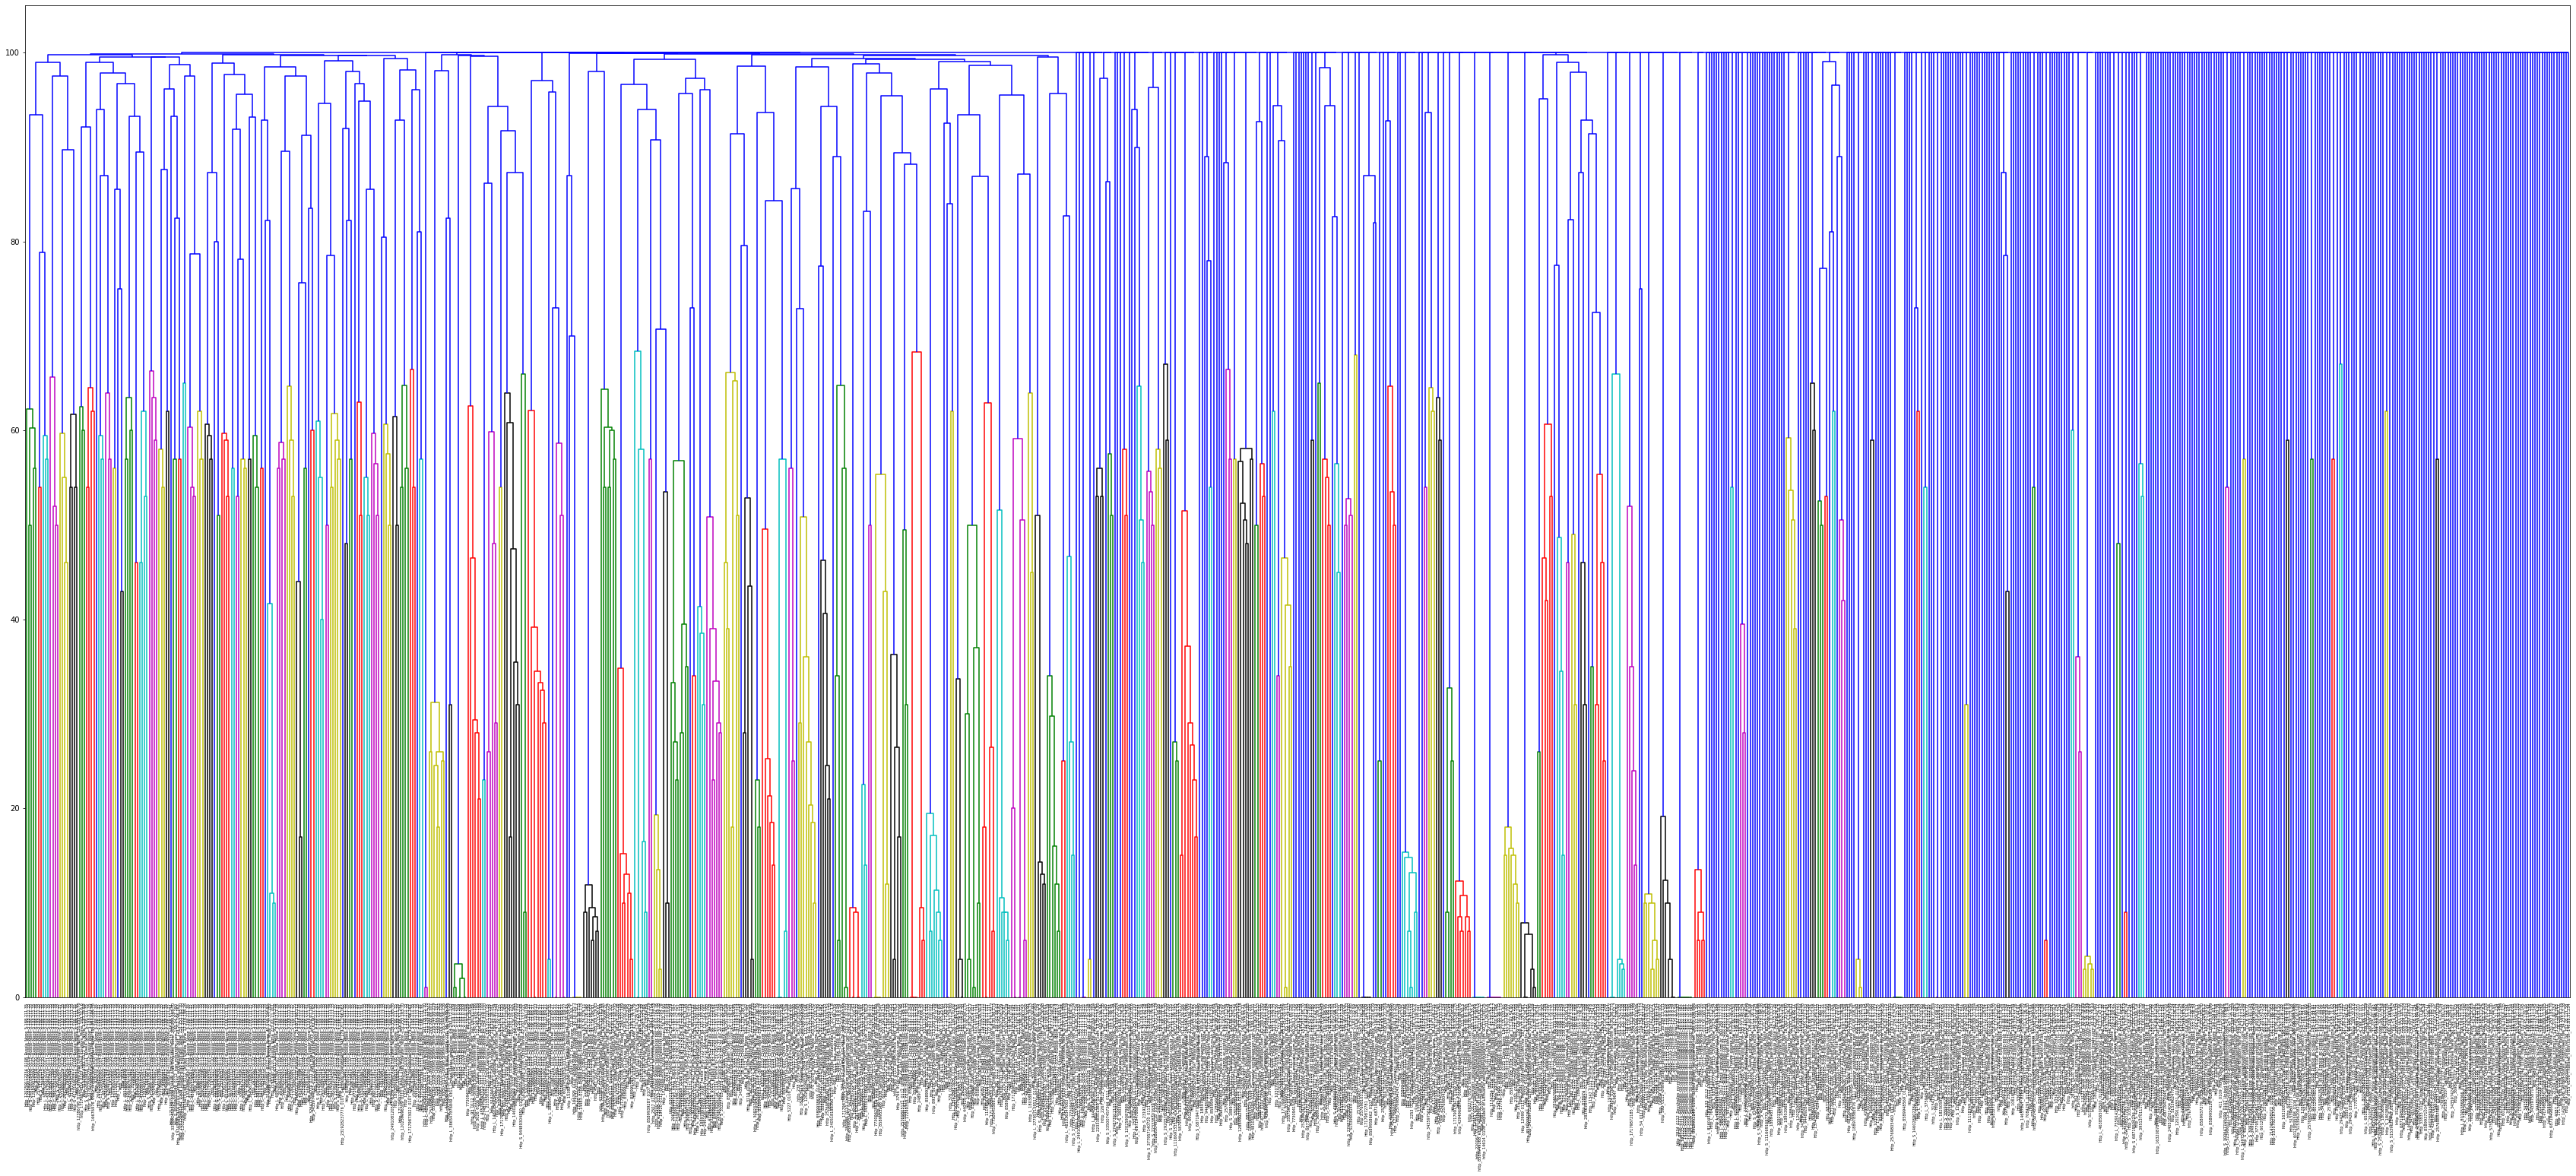

In [47]:
three_upgma_df = pair_wise_score(three_dict) #改!!
dn,Z = draw_upgma(three_upgma_df,
           picture_dir='/home/antslab/spark_data/pcap_inter/2020_01_06/中華電信/case_pictures/' #改!!
           ,name='0106-0112_upgma') #改!! 0106-0112_upgma